# Problem 5 - MARKOV Dynamics + Viterbi + Forecast

## Agenda
- Problem Description
- Problem Implementation
- Alternative Problems
- Wrap-Up

## Problem Description
- <b>Consider a set of variables <i>X</i> whose stochastic processes are known and an electrical quantity <i>y</i> dependent on <i>X</i> and on other variables <i>W</i> whose processes we ignore but for which we can obtain recent historical measurements,
and discover an accurate predictor of <i>y</i> in time <i>t</i> based on the models of <i>X</i> and the forecast of <i>W</i>.</b>

Considered "Kite" 5 Bus Network
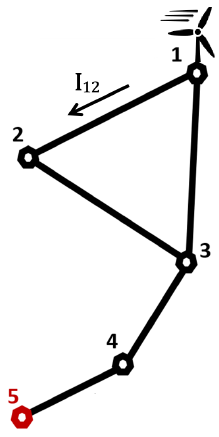

<b>Import Python Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp     #Optimization Library (https://www.cvxpy.org/install/)
from scipy.linalg import block_diag   #Compose matrix for optimization


<b>Parameters

In [2]:
cosPhi=0.95            # Value of teta
time=48                # The time will change in the different steps
networkFactor = 100    # To change the characteristics of the network (Y)

<b>Import data (From Excel file)

In [3]:
Info = np.array(pd.read_excel (r'C:\Data\DASG_Prob2_new.xlsx', sheet_name='Info', header=None))
# Information about the slack bus
SlackBus=Info[0,1]
print ("Slack Bus: ", SlackBus,"\n")

# Network Information
Net_Info = np.array(pd.read_excel (r'C:\Data\DASG_Prob2_new.xlsx', sheet_name='Y_Data'))
print ("Lines information (Admitances)\n", Net_Info, "\n")

#Power Information (Train)
Power_Info = np.array(pd.read_excel (r'C:\Data\DASG_Prob2_new.xlsx', sheet_name='Load(t,Bus)'))
Power_Info = np.delete(Power_Info,[0],1)
print ("Power consumption information (time, Bus)\n", Power_Info, "\n")

#Power Information (Test)
Power_Test = np.array(pd.read_excel (r'C:\Data\DASG_Prob2_new.xlsx', sheet_name='Test_Load(t,Bus)'))
Power_Test = np.delete(Power_Test,[0],1)
print ("Power consumption information (time, Bus)\n", Power_Test, "\n")

P=np.dot(-Power_Info,np.exp(complex(0,1)*np.arccos(cosPhi)))
I=np.conj(P[2,:])


P=np.dot(-Power_Info,np.exp(complex(0,1)*np.arccos(cosPhi)))
#print(P)
I=np.conj(P[2,:])


Slack Bus:  5 

Lines information (Admitances)
 [[1 2 '0,01-0,1i']
 [1 3 '0,02-0,2i']
 [2 3 '0,03-0,2i']
 [3 4 '0,03-0,2i']
 [4 5 '0,02-0,2i']] 

Power consumption information (time, Bus)
 [[0.332 0.064 0.084 0.12 ]
 [0.236 0.164 0.276 0.064]
 [0.224 0.708 1.572 0.072]
 [0.36  3.44  1.188 0.18 ]
 [1.332 2.176 0.484 1.464]
 [1.516 3.02  0.316 0.624]
 [0.92  0.916 0.404 2.772]
 [0.752 0.64  0.396 1.464]
 [1.828 0.684 0.576 0.576]
 [3.568 0.564 0.828 0.428]
 [0.78  0.356 0.728 0.348]
 [0.856 0.22  0.308 0.12 ]
 [0.684 0.528 0.256 0.44 ]] 

Power consumption information (time, Bus)
 [[0.18  0.06  0.188 0.132]
 [0.1   0.06  0.992 0.132]
 [0.388 0.1   1.576 0.132]
 [0.28  0.196 0.08  1.94 ]
 [0.5   0.184 0.064 0.572]
 [1.16  0.108 0.064 0.188]
 [1.036 0.06  0.068 0.08 ]
 [1.036 0.064 0.112 0.064]
 [1.768 0.064 0.2   0.068]
 [0.804 0.092 0.184 0.064]
 [0.824 0.196 0.088 0.096]
 [0.52  0.188 0.064 0.196]
 [0.184 0.104 0.068 0.192]] 



<b>Admittance Matrix(<i>Y</i>); Conductance Matrix(<i>G</i>); Susceptance Matrix(<i>B</i>)

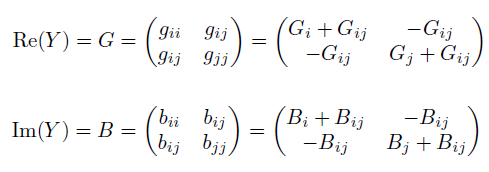

In [4]:
# Determine the number of Bus
nBus=max(np.max(Net_Info[:,0]),np.max(Net_Info[:,1]))

# Create the variable number of lines and the admitance matrix (Y)
nLines=Net_Info.shape[0]

Y=np.zeros((nBus,nBus), dtype=complex)

#Complete the Y matrix nad update the number of lines
for i in range (Net_Info.shape[0]):
    y_aux=Net_Info[i,2].replace(",",".")
    y_aux=y_aux.replace("i","j")
    Y[Net_Info[i,0]-1,Net_Info[i,0]-1]=Y[Net_Info[i,0]-1,Net_Info[i,0]-1]+complex(y_aux)*networkFactor
    Y[Net_Info[i,1]-1,Net_Info[i,1]-1]=Y[Net_Info[i,1]-1,Net_Info[i,1]-1]+complex(y_aux)*networkFactor
    Y[Net_Info[i,0]-1,Net_Info[i,1]-1]=Y[Net_Info[i,0]-1,Net_Info[i,1]-1]-complex(y_aux)*networkFactor
    Y[Net_Info[i,1]-1,Net_Info[i,0]-1]=Y[Net_Info[i,1]-1,Net_Info[i,0]-1]-complex(y_aux)*networkFactor

            
# Remove the slack bus from the admitance matrix            
Yl=np.delete(Y, np.s_[SlackBus-1], axis=0)
Yl=np.delete(Yl, np.s_[SlackBus-1], axis=1)

# Conductance Matrix
G=Yl.real

# Susceptance Matrix
B=Yl.imag 

print("The admitance matrix Y is:\n", Y, "\n")
print("The conductance matrix G is\n", G, "\n")
print("The susceptance matrix B is\n",B, "\n")

The admitance matrix Y is:
 [[ 3.-30.j -1.+10.j -2.+20.j  0. +0.j  0. +0.j]
 [-1.+10.j  4.-30.j -3.+20.j  0. +0.j  0. +0.j]
 [-2.+20.j -3.+20.j  8.-60.j -3.+20.j  0. +0.j]
 [ 0. +0.j  0. +0.j -3.+20.j  5.-40.j -2.+20.j]
 [ 0. +0.j  0. +0.j  0. +0.j -2.+20.j  2.-20.j]] 

The conductance matrix G is
 [[ 3. -1. -2.  0.]
 [-1.  4. -3.  0.]
 [-2. -3.  8. -3.]
 [ 0.  0. -3.  5.]] 

The susceptance matrix B is
 [[-30.  10.  20.   0.]
 [ 10. -30.  20.   0.]
 [ 20.  20. -60.  20.]
 [  0.   0.  20. -40.]] 



<b> Errors Definition

Random values considering a normal distribution

In [5]:
np.random.seed(98)
e1=np.random.randn(time)*0.5
e=np.random.randn(4,time)*0.15

To obtain the same values of lecture notes, we should use the following errors

In [6]:
e1 = [  0.2878,   0.0145,   0.5846,  -0.0029,  -0.2718,  -0.1411,
       -0.2058,  -0.1793,  -0.9878,  -0.4926,  -0.1480,   0.7222,
       -0.3123,   0.4541,   0.9474,  -0.1584,   0.4692,   1.0173,
       -0.0503,   0.4684,  -0.3604,   0.4678,   0.3047,  -1.5098,
       -0.5515,  -0.5159,   0.3657,   0.7160,   0.1407,   0.5424,
        0.0409,   0.0450,   0.2365,  -0.3875,   1.4783,  -0.8487,
       -0.0211,   0.0266,   0.4451,   0.4663,   0.3200,  -0.1156,   
       -0.4587,  -0.5685,  -0.5464,  -0.2405,  -0.3513,   -0.3781]


e =  [[ 0.0925,  -0.2709,  -0.0663,  -0.0486,  -0.0194,  -0.0288,
       -0.0961,   0.0720,   0.0084,  -0.0848,   0.0453,   0.1048,
        0.0801,  -0.2532,   0.0692,  -0.0930,   0.2247,  -0.0583,
        0.1100,   0.0159,   0.1016,  -0.0278,  -0.0942,  -0.0101,
       -0.0428,   0.0711,   0.1195,   0.0303,  -0.2142,  -0.0605,
       -0.0793,   0.1686,  -0.0161,  -0.0191,  -0.3057,  -0.0787,
       -0.0235,  -0.0007,  -0.2525,  -0.1399,   0.0970,   0.0330,
       -0.3454,  -0.0300,   0.1832,   0.0803,  -0.0141,  -0.0123],
      [-0.0056,  -0.1072,  -0.0848,  -0.0014,  -0.0642,  -0.0522,
        0.0415,  -0.1746,  -0.0378,  -0.0668,   0.1215,  -0.1230,
       -0.1058,  -0.1673,  -0.1110,  -0.0361,  -0.0813,   0.0340,
       -0.2259,   0.3126,  -0.0760,   0.0552,  -0.0117,   0.0853,
       -0.1266,   0.0981,  -0.1846,   0.0642,  -0.2060,   0.0298,
       -0.0203,   0.1678,  -0.1196,   0.0370,  -0.2070,  -0.0424,
       -0.0182,   0.2051,   0.0612,  -0.0256,  -0.0363,  -0.1274,
       -0.0144,   0.1213,   0.0474,   0.0452,   0.1294,  -0.0838],
      [-0.1015,  -0.1218,  -0.3540,  -0.0333,  -0.0507,  -0.1101,
        0.1679,   0.0920,   0.0451,  -0.0653,   0.2127,   0.0137,
       -0.1283,   0.2646,   0.3626,  -0.1312,  -0.0740,   0.0016,
        0.2988,   0.2222,   0.0487,   0.0710,   0.1491,  -0.0412,
       -0.0436,  -0.0005,  -0.0708,   0.1466,   0.3735,  -0.2760,
       -0.2327,   0.2841,  -0.2430,  -0.2334,  -0.0864,   0.0692,
        0.0447,   0.0375,  -0.1278,   0.0254,  -0.1437,  -0.2031,
        0.0113,  -0.2351,  -0.3242,  -0.0833,  -0.2619,   0.1001],
      [ 0.1327,  -0.2181,  -0.1038,   0.1115,  -0.0446,  -0.0859,
       -0.1246,   0.1313,   0.2358,  -0.0910,  -0.1343,  -0.0258,
        0.3350,  -0.0661,   0.0017,  -0.0668,   0.1063,   0.1508,
        0.1718,   0.0782,  -0.0191,   0.0773,   0.0475,   0.0306,
       -0.0054,  -0.0963,  -0.4423,   0.0650,  -0.3559,  -0.0976,
       -0.1173,  -0.1590,  -0.0633,  -0.1842,   0.1666,   0.1624,
        0.2661,   0.2032,  -0.2687,   0.0535,   0.0120,   0.2273,
        0.0263,  -0.1072,   0.0176,  -0.0135,  -0.0401,  -0.1862]]

e = np.array(e)

<b> Determine the wind generation and the load flow in <i>I<sub>12

In [7]:
#Creation of Matrix
II=np.zeros((nBus-1,time), dtype=complex)
i12=np.zeros(time)
i1w=np.zeros(time)

# Initializing the process of data generation
II[:,0]=I                                      #Power Injections
v=1+np.dot(np.linalg.inv(Yl),I)
i12[0]=np.absolute(np.dot(Y[0,1],v[0]-v[1]))   #Current I12 in period t=0
i1w[0]=np.real(I[0])                           #Injection in bus 1 (Wind) in period t=0

# Process of data generation
for t in range(time-1):             
    II[:,t+1]=0.999*II[:,t]+e[2,t]                        # Power injection based on previous periods and in the errors. T
                                                          # the values are more or less related considering 
                                                          # the value of 0.95. This value can change between 0 and 1.  
    i1w[t+1]=0.75*i1w[t]+e1[t]                            # Wind power based on the previous periods  
    II[0,t+1]=i1w[t+1]+np.complex(0,np.imag(II[0,t+1]))   # Add the Wind generation 
    v=1+np.dot(np.linalg.inv(Yl),II[:,t+1])               # Compute the voltages
    I12=np.dot(-Y[0,1],v[0]-v[1])                         # Compute the load flow in line 1-2 (Complex)
    i12[t+1]=np.absolute(I12)*np.sign(np.real(I12))       # Compute the load flow in line 1-2 (RMS with signal)

    
print ('The power injection in Bus 1 is:\n',II[0,:])
print ('\nThe power flow in Line 1-2 is:\n',i12)

The power injection in Bus 1 is:
 [-0.2128    +0.06994398j  0.1282    +0.06987403j  0.11065   +0.06980416j
  0.6675875 +0.06973436j  0.49779063+0.06966462j  0.10154297+0.06959496j
 -0.06494277+0.06952536j -0.25450708+0.06945584j -0.37018031+0.06938638j
 -1.26543523+0.06931699j -1.44167642+0.06924768j -1.22925732+0.06917843j
 -0.19974299+0.06910925j -0.46210724+0.06904014j  0.10751957+0.0689711j
  1.02803968+0.06890213j  0.61262976+0.06883323j  0.92867232+0.06876439j
  1.71380424+0.06869563j  1.23505318+0.06862693j  1.39468988+0.06855831j
  0.68561741+0.06848975j  0.98201306+0.06842126j  1.04120979+0.06835284j
 -0.72889265+0.06828449j -1.09816949+0.0682162j  -1.33952712+0.06814799j
 -0.63894534+0.06807984j  0.236791  +0.06801176j  0.31829325+0.06794375j
  0.78111994+0.0678758j   0.62673995+0.06780793j  0.51505496+0.06774012j
  0.62279122+0.06767238j  0.07959342+0.06760471j  1.53799506+0.0675371j
  0.3047963 +0.06746956j  0.20749722+0.06740209j  0.18222292+0.06733469j
  0.58176719+0.0672

<b> Plot the input data (Page 65 of the lectures)

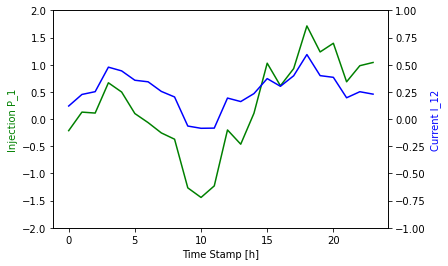

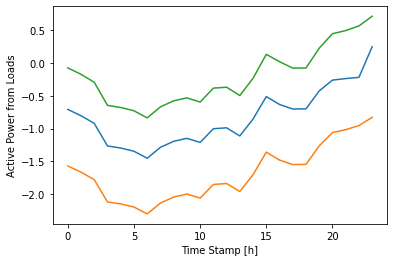

In [8]:
TPlot=24                  #Define a time to plot

# Define the plots
x = range(TPlot)
yy1 = i12[0:TPlot]
yy2 = i1w[0:TPlot]
yy3 = np.absolute(II[:,0:TPlot])*np.sign(np.real(II[:,0:TPlot])) 

#First Graph (Pinjection in bus 1 and Current I12)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(x, yy2, 'g-')
ax2.plot(x, yy1, 'b-')
ax1.set_xlabel('Time Stamp [h]')
ax1.set_ylabel('Injection P_1', color='g')
ax2.set_ylabel('Current I_12', color='b')
ax1.set_ylim([-2, 2])
ax2.set_ylim([-1, 1])
plt.xlabel("Time Stamp [h]")
plt.show()

#Power From Loads
for i in range (3):
    y4 = yy3[i+1,:]
#    ll=('Conso '+  str(i))
    plt.plot(x, y4)
plt.xlabel("Time Stamp [h]")
plt.ylabel("Active Power from Loads")
#plt.legend()
plt.show()



<b><u>MARKOV Chain</u></b>

Assuming we have recent measurements of both <i>y<sub>t</sub></i> and <i>W<sub>t</sub></i>,
<i>t = 1, . . . , t<sub>0</sub></i>, we first have to be able to estimate <i>X<sub>t0</sub></i>. Because <i>X<sub>t</sub></i> is a Markov process whose state cannot be observed directly in real-time, the problem of estimating $X_{t0}$ based on <i>y<sub>t</sub></i> and <i>W<sub>t</sub></i> is a Hidden Markov Model (HMM) problem.

<b>Discretization of the injection data
    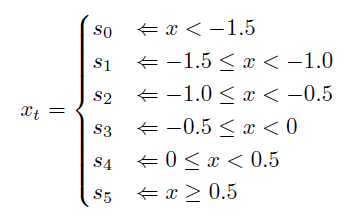

In [31]:
# The variables of Markov Chain are:
#  - y -> The measurement of current in branch 1-2
#  - w -> The measurement of wind power injection
#  - X -> The power injections

#Definition of variables y and x
y=i12[:]
W=i1w[:]
X=np.transpose(np.real(II[1:4,:]))
Xd=np.round(2*X)/2   # To have the variable X rounded according the state limits

#Definition of the States s
s=[-1.5, -1, -0.5, 0, 0.5, 1]

# Definition of the number/percentage of measurements in each state
pp=np.zeros([6])
pp[0]=np.sum(np.sum(Xd<=s[0]))
pp[1]=np.sum(np.sum(Xd==s[1]))
pp[2]=np.sum(np.sum(Xd==s[2]))
pp[3]=np.sum(np.sum(Xd==s[3]))
pp[4]=np.sum(np.sum(Xd==s[4]))
pp[5]=np.sum(np.sum(Xd>=s[5]))
ppi=pp/np.sum(pp)

print ('The number of measurements in each state are:\n',pp)
print ('\nThe percentage of measurements in each state are:\n',ppi)
print ('\n',X)
print ('\n',Xd)

The number of measurements in each state are:
 [30. 32. 30. 29. 20.  3.]

The percentage of measurements in each state are:
 [0.20833333 0.22222222 0.20833333 0.20138889 0.13888889 0.02083333]

 [[-6.72600000e-01 -1.49340000e+00 -6.84000000e-02]
 [-7.73427400e-01 -1.59340660e+00 -1.69831600e-01]
 [-8.94453973e-01 -1.71361319e+00 -2.91461768e-01]
 [-1.24755952e+00 -2.06589958e+00 -6.45170307e-01]
 [-1.27961196e+00 -2.09713368e+00 -6.77825136e-01]
 [-1.32903235e+00 -2.14573655e+00 -7.27847311e-01]
 [-1.43780331e+00 -2.25369081e+00 -8.37219464e-01]
 [-1.26846551e+00 -2.08353712e+00 -6.68482244e-01]
 [-1.17519705e+00 -1.98945358e+00 -5.75813762e-01]
 [-1.12892185e+00 -1.94236413e+00 -5.30137948e-01]
 [-1.19309293e+00 -2.00572176e+00 -5.94907810e-01]
 [-9.79199834e-01 -1.79101604e+00 -3.81612903e-01]
 [-9.64520634e-01 -1.77552503e+00 -3.67531290e-01]
 [-1.09185611e+00 -1.90204950e+00 -4.95463758e-01]
 [-8.26164258e-01 -1.63554745e+00 -2.30368295e-01]
 [-4.62738093e-01 -1.27131190e+00  1.324

<b>Transition matrix for Homogeneous Markov Process
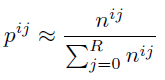

In [10]:
# Create Variables
nStates=6    #Number of States
kPeriod=24   #Number of periot until t0  
nLoads=3     #Number of Loads
n=np.zeros(([nStates,nStates]))

#Number of times that the state i change to state j
for t in range(time-1):
    for m in range(nLoads):
        for i in range(nStates):
            for j in range (nStates):
                if Xd[t,m]==s[i] and Xd[t+1,m]==s[j]:
                    n[i,j]=n[i,j]+1

#Probability Pij (in Homogeneous process)
nij=n/(np.sum(n,axis=0))

print ('The number of transitions (k=1) are:\n',n)
print ('\nThe probability of transitions (k=1) are:\n',nij)


The number of transitions (k=1) are:
 [[11.  2.  0.  0.  0.  0.]
 [ 3. 23.  5.  0.  0.  0.]
 [ 0.  7. 19.  4.  0.  0.]
 [ 0.  0.  5. 21.  3.  0.]
 [ 0.  0.  0.  3. 15.  2.]
 [ 0.  0.  0.  0.  2.  1.]]

The probability of transitions (k=1) are:
 [[0.78571429 0.0625     0.         0.         0.         0.        ]
 [0.21428571 0.71875    0.17241379 0.         0.         0.        ]
 [0.         0.21875    0.65517241 0.14285714 0.         0.        ]
 [0.         0.         0.17241379 0.75       0.15       0.        ]
 [0.         0.         0.         0.10714286 0.75       0.66666667]
 [0.         0.         0.         0.         0.1        0.33333333]]


<b>Transition matrix for Non-Homogeneous Markov Process</b>

A possible approach to parametrize a non-homogeneous Markov
process representative of a given period is to adjust $\pi_s$ and $P$ for
every time-period $k$. The adjusted variables are named $\pi_{s,k}$ and
$P_k$. The values of $\pi_{s,k}$ can be obtained from $\pi_s$ with:
    
    
 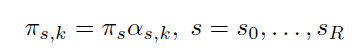


The adjusting coefficients $\pi_{s,k}$ should force the expected load in period k to be equal to time-series average μk and the sum of $\pi_{s,k}$  to be unitary. These constraints can be written as $A\alpha_{s,k}=b_k$ where,
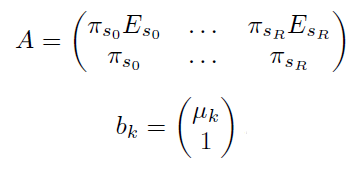

<b>Generic Optimization Function (Quadratic Problem)
    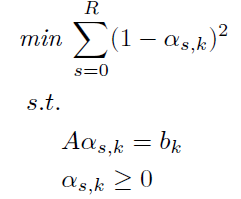

In [11]:
def OptFunc (A,b,C,d,lb,ub):
    # Problem data.
    n = np.shape(C)[1]

    # Construct the problem.
    x = cp.Variable(n)
    objective = cp.Minimize(cp.sum_squares(C@x - d))
    constraints = [lb <= x, x <= ub, A@x-b<=0, A@x-b>=0]
    prob = cp.Problem(objective, constraints)

    # The optimal objective value is returned by `prob.solve()`.
    result = prob.solve(solver='OSQP')

    return x.value, prob.solve(), prob.status
    

<b>Transition Matrices for each period $k$
    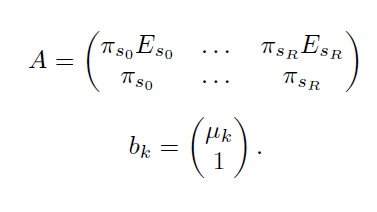
    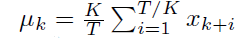

In [26]:
#Create variables
mu=np.zeros(time)
b=np.ones(([time,2]))*1.0
a=np.zeros(([time,nStates]))

#Everage values of load
for t in range(time):
    mu[t]=np.sum(X[t,:])/3  #Compute the values of micro_k (expected load)
    b[t,0]=mu[t]            #Compute the matrix B. The elements of second column are one 
                            #because is the total probability 

#Compute matrix A, considering the probabilities of first period
A=np.vstack((s*ppi, ppi))

#Compute matrix C (Diagonal with ones)
C=np.zeros(([nStates,nStates]))
np.fill_diagonal(C,1)

#Compute matric D (Vector with ones)
d=np.ones(nStates)

#Lower Bound
lb=np.ones(nStates)*0.01

#Upper Bound
ub=np.ones(nStates)*np.inf

#Compute the value of alfa (matrix a) for each time period
for t in range(time):
    a[t,:], OptValue, OptStatus=OptFunc (A,b[t,:],C,d,lb,ub)   #Optimization

    #If the solver not return a solution, we can try to relax the problem. 
    #In that case, we will consider that the sum of the probabilities can be higher than 1. 

    while (np.isnan(a[t,0])):
        b[t,1]=b[t,1]+0.0025     #We are relaxing the problem in steps of 0.0025
        a[t,:], OptValue, OptStatus=OptFunc (A,b[t,:],C,d,lb,ub) #Do optimization again  

print('The values of Alfa are\n',a)


The values of Alfa are
 [[1.42664678 1.18992682 0.92946602 0.69151312 0.62152351 0.91836949]
 [1.64582199 1.28749177 0.89322508 0.53302908 0.42708545 0.87643297]
 [1.90888511 1.404596   0.84973238 0.34281748 0.19371977 0.82610033]
 [3.23654257 1.41302373 0.01       0.01       0.01       0.29898785]
 [3.46883797 1.21275858 0.01       0.01       0.01       0.11219539]
 [3.90170519 0.81652638 0.01       0.01       0.01       0.01      ]
 [4.80121682 0.04073423 0.01       0.01       0.01       0.01      ]
 [3.38630843 1.28390847 0.01       0.01       0.01       0.17855873]
 [2.84054549 1.56570127 0.22014439 0.01       0.01       0.52895428]
 [2.63189297 1.56290857 0.4235606  0.01       0.01       0.6111062 ]
 [2.92046783 1.56677099 0.14222778 0.01       0.01       0.49748677]
 [2.0917936  1.48601888 0.81949179 0.21056285 0.03145998 0.79110391]
 [2.05971259 1.47173781 0.8247958  0.2337595  0.05991935 0.79724206]
 [2.46373715 1.5606579  0.58749641 0.01       0.01       0.67731353]
 [1.758491

array([1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.015 , 1.    ,
       1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
       1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
       1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
       1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
       1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.0425])

<b>The adjusted variables $\pi_{s,k}$ and $P_k$ are:
    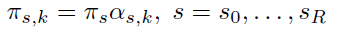

In [13]:
#Create Matrix
pi_k=np.zeros(([time,nStates]))
pi_k1=np.zeros(([time,nStates]))
pp=np.zeros(nStates)
pi_emp=np.zeros(([time,nStates]))

#Compute the value of Pi_s,k
for t in range(time):
    pi_k1[t,:]=np.multiply(np.transpose(ppi),np.transpose(a[t,:])) #Compute Pi*Alpha
    #Over-right pi_k with hourly values
    pp[0]=np.sum(np.sum(Xd[t,:]<=s[0]))
    pp[1]=np.sum(np.sum(Xd[t,:]==s[1]))
    pp[2]=np.sum(np.sum(Xd[t,:]==s[2]))
    pp[3]=np.sum(np.sum(Xd[t,:]==s[3]))
    pp[4]=np.sum(np.sum(Xd[t,:]==s[4]))
    pp[5]=np.sum(np.sum(Xd[t,:]>=s[5]))
    pi_emp[t,:]=pp/3

pi_k=pi_emp

print ("The computed values of 𝜋𝑠,𝑘 are:\n",pi_k1)
print ("The over-right values of 𝜋𝑠,𝑘 are:\n",pi_k)

The computed values of 𝜋𝑠,𝑘 are:
 [[2.97218078e-01 2.64428183e-01 1.93638754e-01 1.39263059e-01
  8.63227095e-02 1.91326977e-02]
 [3.42879580e-01 2.86109282e-01 1.86088559e-01 1.07346134e-01
  5.93174242e-02 1.82590203e-02]
 [3.97684398e-01 3.12132443e-01 1.77027580e-01 6.90396321e-02
  2.69055235e-02 1.72104235e-02]
 [6.74279702e-01 3.14005274e-01 2.08333333e-03 2.01388889e-03
  1.38888889e-03 6.22891346e-03]
 [7.22674578e-01 2.69501907e-01 2.08333333e-03 2.01388889e-03
  1.38888889e-03 2.33740406e-03]
 [8.12855248e-01 1.81450308e-01 2.08333333e-03 2.01388889e-03
  1.38888889e-03 2.08333333e-04]
 [1.00025350e+00 9.05205173e-03 2.08333333e-03 2.01388889e-03
  1.38888889e-03 2.08333333e-04]
 [7.05480922e-01 2.85312994e-01 2.08333333e-03 2.01388889e-03
  1.38888889e-03 3.71997345e-03]
 [5.91780310e-01 3.47933616e-01 4.58634156e-02 2.01388889e-03
  1.38888889e-03 1.10198807e-02]
 [5.48311036e-01 3.47313016e-01 8.82417909e-02 2.01388889e-03
  1.38888889e-03 1.27313792e-02]
 [6.08430797e-01

<b>New transition matrices $P_{ij}$ for each period $k$
    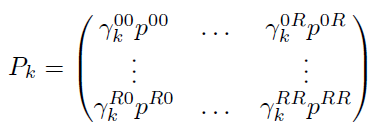

Also see Equations 41 to 47 of lectures

In [14]:
#Create Matrices
g=np.zeros(([time,nStates**2]))  #Matrix with the results
C=np.diag(np.diag(np.ones(([nStates**2,nStates**2]))))  #Part of Objective Function
d=np.ones(nStates**2)                                   #Part of Objective Function
lb=np.zeros(nStates**2)                                 #Lower Bound 
ub=np.ones(nStates**2)*np.inf                           #Upper Bound

#Compose the matrices for the optimization
for t in range(1,time):
    Ck=0
    D=0
    Ck=np.multiply(pi_k[t-1,:],np.transpose(nij[:,0]))   #See Eq. 40 and 41 of the lectures
    D=np.diag((nij[:,0]))                                #See Eq. 44 of the lectures.  
    for i in range(nStates-1):
        F=np.multiply(pi_k[t-1,:],np.transpose(nij[:,i+1])) #See Eq. 41 of the lectures
        Ck=block_diag(Ck,F)                              #See Eq. 40
        G=np.diag((nij[:,i+1]))                          #See Eq. 45 of the lectures
        D=np.hstack((D,G))                               #See Eq. 44 of the lectures
    Ak=np.vstack((Ck,D))
    A_aux=pi_k[t,:]
    bk=np.hstack((pi_k[t,:],np.ones(nStates)))
    #Optimization
    sol, OptValue, OptStatus=OptFunc (Ak,bk,C,d,lb,ub)  #See Eq. 47
    #Evaluate if the optimal solution is achieved
    if OptStatus=="optimal":
        g[t,:]=sol
    else:
        g[t,:]=1
    

print ('The value of the adjusting coefficient Gamma_ij is \n',g)

The value of the adjusting coefficient Gamma_ij is 
 [[0.         0.         0.         ... 0.         0.         0.        ]
 [1.27265608 0.96184642 1.         ... 1.         0.65711105 2.55963303]
 [1.1752419  0.35726603 1.         ... 1.         0.65711105 2.55963303]
 ...
 [1.1752419  0.35726603 1.         ... 1.         0.65711105 2.55963303]
 [1.17688717 0.35156603 1.         ... 1.         0.65711105 2.55963303]
 [1.27279858 4.66615608 1.         ... 1.         0.65711105 2.55963303]]


<b>Markov chain trajectories in the state space of $X_t$

Having determined the optimum variations, $\gamma_k$, the new matrix $P_k=(p^{ij}_k)$ is obtained by varying its elements accordingly, i.e.,$p^{ij}_k\leftarrow p^{ij}\gamma^{ij}_k$.



In [27]:
#Create matrices
nSamples=590
pijSt=np.zeros([time,nStates,nStates])
Xs=np.zeros(([nSamples,time]))

#for each sample
for ii in range(nSamples):
    #Create matrix of states 
    xx=np.zeros(time)

    #The initial state is s1
    xx[0]=2

    #Generate a random value. This value is used to define the transition between periods k 
    tj=np.random.random(time-1)

    #Definition of the trajetories in the state space
    for t in range(1,time):
        gg=np.reshape(g[t,:],(nStates,nStates))
        pij=np.transpose(np.multiply(np.transpose(nij),gg))  #Eq.39 of the lectures
        if ii==0:                       # This is only to print the two Pij in the first two k
            pijSt[t-1,:,:]=pij

        iis=np.int(xx[t-1])             # State in the previous period
        cum=0
        xx[t]=xx[t-1]

        #Definitio of the state in next period
        for j in range (nStates):
            cum=cum+pij[iis-1,j]
            if cum >= tj[t-1]:
                xx[t]=j+1
                break
    Xs[ii,:]=(xx-4)/2;
            

pijSt[1,:,:]
print ('Example of first two time periods, k=1,2 (Example of page 70)\nP1=\n',pijSt[0,:,:])
print ('\nP2=\n',pijSt[1,:,:])


Example of first two time periods, k=1,2 (Example of page 70)
P1=
 [[ 9.99944061e-01  1.11528203e-04  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 2.06109947e-01  6.26769068e-01  1.67120986e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  9.99889128e-01 -1.18692155e-05  1.06931383e-04
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  3.95664819e-05  9.99925965e-01
   1.33777384e-06  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.01238519e-01
   4.60687448e-01  4.38074033e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.46788991e-01  8.53211009e-01]]

P2=
 [[9.23404353e-01 7.66347792e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.65570061e-02 9.23346491e-01 1.14760860e-04 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.17136109e-01 6.40695055e-01 1.42168836e-01
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.9

<b>24-period non-homogeneous Markov chain trajectories in the state space of $X_t$ obtained by sampling with $Pr(X_{t+1} = x  |  X_t = x_t) \quad \textrm{for} \quad x_1 = s_1$

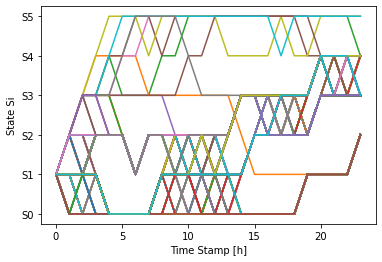

In [28]:
# Define the plots
x = range(kPeriod)

for i in range (nSamples):
    y4 = Xs[i,0:kPeriod]
    plt.plot(x, y4)

plt.xlabel("Time Stamp [h]")
plt.ylabel("State Si")
statesD = ['S0', 'S1', 'S2', 'S3', 'S4', 'S5']
y_pos = np.arange(len(statesD))/2-1.5
#x_pos = [0,10,20,30,40]
#timePos = ['0', '5', '10', '15', '20']
plt.yticks(y_pos, statesD)
plt.show()

#plt.legend()
plt.show()

<b><u>Viterbi values

To compute the Viterbi values, $V_{t,i}$, for each state $s_i$, we need to define the output probability density function $Pr(y_t|s_i)$ as a function of the observed outputs, $y_t$ and $W_t$. One possible way to define such function is to define it as a logistic over a random variable that is an estimation error $\epsilon_{t,i}$.

In [17]:
#Create Matrices
cs=0.1    #Scale parameter
i12_s=np.zeros(kPeriod)
ee=np.zeros([nStates,kPeriod])
VV=np.zeros([nStates,kPeriod])
ptr=np.zeros([nStates,kPeriod])
Ss=np.zeros(kPeriod)
Vs=np.zeros(kPeriod)
e_min=np.zeros(kPeriod)


sm=np.mean(s, axis=0)    #Average of states spaces
xlm=np.mean(X, axis=0)   #Average of power injections

# Compute the current i12 considering the relation between the state value and the real value (xlm-sm)
#In the end, we can evaluate the error (variavle ee) comparing the new i12 and the previous one 
for t in range(kPeriod):
    for i in range(nStates):
        inj=s[i]+xlm-sm
        III=np.divide(np.concatenate((W[t], inj), axis=None),np.dot(0.95,np.exp(complex(0,1)*np.arccos(cosPhi))))
        vvv=1+np.dot(np.linalg.inv(Yl),np.conjugate(III))
        I12_s=np.dot(-Y[0,1],vvv[0]-vvv[1])
        i12_s[t]=np.absolute(I12_s)*np.sign(np.real(I12_s))
        ee[i,t]=y[t]-i12_s[t]   #error of the original value i12 and the new one. Eq(52)

#Logistic Distribution
pv=np.multiply(np.exp(np.divide(-ee,cs)),(1+np.exp(np.divide(-ee,cs)))**-2)  #Eq (53)

print ('The Logistic distribution is:\n',pv)

The Logistic distribution is:
 [[0.04865602 0.0563805  0.0730648  0.13395961 0.14362682 0.16100718
  0.18922424 0.15239649 0.13316582 0.10504572 0.12604766 0.08395693
  0.0883109  0.11716095 0.06330375 0.02433082 0.03500544 0.03962534
  0.03558327 0.01874746 0.01071565 0.01059748 0.00849936 0.00585149]
 [0.13904982 0.15467312 0.18350562 0.24236356 0.24617536 0.2497297
  0.24672702 0.24848857 0.24198959 0.21312    0.24109305 0.19304736
  0.2045563  0.23242751 0.16742027 0.07911155 0.10754331 0.11877837
  0.1089577  0.0627994  0.03747238 0.03708988 0.03008166 0.02100715]
 [0.24453838 0.2489157  0.24822339 0.20051995 0.19098948 0.17365898
  0.14538328 0.1822735  0.20132644 0.22596695 0.20561009 0.24223084
  0.24030482 0.21667574 0.24999995 0.19238972 0.22473944 0.23357082
  0.22593924 0.16648491 0.11359023 0.1126819  0.09484951 0.06951878]
 [0.19565683 0.17998834 0.15114183 0.08513829 0.07812641 0.0669397
  0.05169824 0.07264437 0.08530509 0.10937612 0.08948076 0.13417675
  0.1299006  0.0

<b>24-period output probabilities $Pr(y_t|s_i)$ computed with Eq.(53).

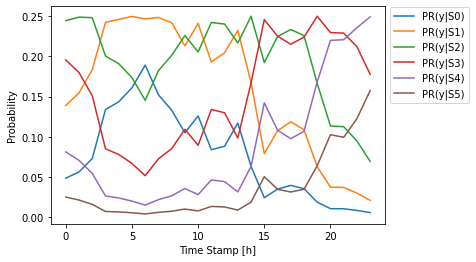

In [18]:
# Define the plots
x = range(kPeriod)
yy1=pv

for i in range (nStates):
    y4 = yy1[i,:]
    ll=('PR(y|S'+  str(i)+')')
    plt.plot(x, y4, label=ll)

plt.xlabel("Time Stamp [h]")
plt.ylabel("Probability")
plt.legend(bbox_to_anchor=(1, 1.02),loc='upper left')
plt.show()

<b> Viterbi Path

Once we have computed the output probabilities, we then:

 • May use $\pi_{s_i,1}$ obtained from Eq. (35) to compute $V_{1,i} = Pr(y_1 | s_i)\pi_{s_i,1}$; 
 
 and then
 
• Recursively iterate forward in time to compute $V_{t,i} = max_{x\in S}\{Pr(y_t|s_i)p^{x,s_i}_{t-1}V_{t-1,x}\}$

In [29]:
#Compute V1,i
VV[:,0]=np.multiply(pv[:,0],np.transpose(pi_k[0,:]))

#Recursively iterate forward in time to compute  𝑉𝑡,𝑖. 
#The matrix VV gave the probability to be in each state in period 24
#The matrix ptr is the pointer with the information about the most probable previous state
for t in range(1,kPeriod):
                               #Eq(35)
# Let the pointer ptr(si,t) be the function that returns the value of x used to compute Vt,si if t>1 or si if t=1. Then
                               #Eq.(50)
                               #Eq.(51)     

#Most probable state in t=24                
                                 #Max Probability
                                 #State of max probability

#Start the backward vectors                



print ('The most probable states are:\n',Ss,'\n')
print ('The probability is:\n',Vs,'\n')
print ('The error is:\n',e_min)


The most probable states are:
 [4. 4. 3. 3. 3. 3. 2. 3. 3. 3. 3. 3. 3. 3. 4. 4. 4. 4. 4. 4. 5. 5. 5. 5.] 

The probability is:
 [0.06521894 0.26086128 0.44082906 0.64019752 0.84070365 1.03169321
 1.20533592 1.45206277 1.63432337 1.79602465 1.97751668 2.14265893
 2.33721379 2.53022171 2.74689731 2.91414856 3.12007582 3.30887201
 3.48915971 3.67696481 3.92695855 4.11946478 4.31267426 4.51897207] 

The error is:
 [ 0.1010491   0.11780508  0.01690004  0.09566028  0.10612053  0.12442262
  0.02298464  0.11540131  0.09475434  0.06412057  0.08987333  0.03562932
  0.03990696  0.07655124  0.13108588  0.02632402  0.0650995   0.07849653
  0.06674903 -0.00096105  0.07225445  0.07119442  0.04866757  0.01079057]


array([[0.01621867, 0.08151279, 0.33786537, 0.48265961, 0.84476711,
        0.9883938 , 1.1493971 , 1.33861446, 1.45206277, 1.63432337,
        1.79602465, 1.97751668, 2.14265893, 2.33721379, 2.53022171,
        2.74689731, 2.91414856, 3.12007582, 3.30887201, 3.48915971,
        3.67696481, 3.92695855, 4.11946478, 4.31267426],
       [0.        , 0.32602406, 0.46884094, 0.60241347, 0.64020896,
        0.84476728, 1.20533592, 1.20532459, 1.45208863, 1.67395313,
        1.84050472, 2.01798678, 2.19034043, 2.38451617, 2.59912221,
        2.74689731, 2.91414856, 3.12007582, 3.30887201, 3.48915971,
        3.67696481, 3.92695855, 4.11946478, 4.31267426],
       [0.08151279, 0.08150989, 0.44082906, 0.64019752, 0.84070365,
        1.03169321, 1.03170122, 1.45206277, 1.63432337, 1.79602465,
        1.97751668, 2.14265893, 2.33721379, 2.53022171, 2.53021487,
        2.76653775, 2.95393933, 3.1565564 , 3.35230336, 3.54161336,
        3.67696341, 3.92695855, 4.11946478, 4.31267426],
       [0.065

<b>Markov chain trajectories in the state space of injections

In [20]:
#Create matrices
nSamplesV=500
Xsv=np.zeros(([nSamplesV,kPeriod]))

#for each sample
for ii in range(nSamplesV):
    #Create matrix of states 
    
    #The initial state is the result of previous function

    #Generate a random value. This value is used to define the transition between periods k 

    #Definition of the trajetories in the state space
    for t in range(kPeriod-2,-1,-1):
                                                               #Eq.39 of the lectures
        iisv=np.int(xxv[t+1])                                  # State in the previous period
        
        #Definition of the state in next period

#Most probable path defined in the previous period. In that case considering the state values "s"   


<b>24-period minimal estimation error $\epsilon_{t,i}$ (top plot) and the
optimal Viterbi path in the state space of the injections that minimize
such error (bottom plot).

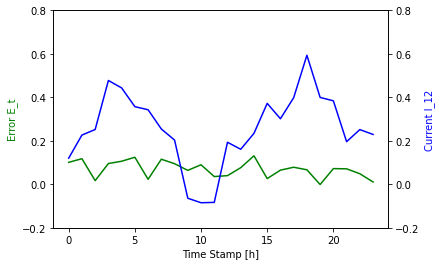

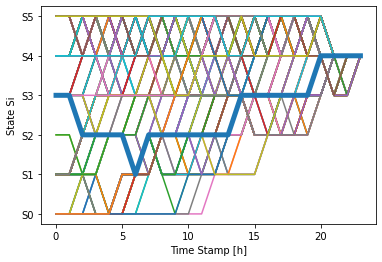

In [21]:
# Define the plots
x = range(kPeriod)
y1 = e_min
y2 = i12[0:kPeriod]
y3 = xsv

#Graph 1

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')
ax1.set_xlabel('Time Stamp [h]')
ax1.set_ylabel('Error E_t', color='g')
ax2.set_ylabel('Current I_12', color='b')
ax1.set_ylim([-0.2, 0.8])
ax2.set_ylim([-0.2, 0.8])
plt.xlabel("Time Stamp [h]")
plt.show()


#Grahp 2
for i in range (nSamplesV):
    y4 = Xsv[i,:]
    plt.plot(x, y4)
plt.plot(x,xsv, linewidth=5)
    
#plt.legend()
plt.xlabel("Time Stamp [h]")
plt.ylabel("State Si")
statesD = ['S0', 'S1', 'S2', 'S3', 'S4', 'S5']
y_pos = np.arange(len(statesD))/2-1.5
plt.yticks(y_pos, statesD)
plt.show()

